In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy import interpolate

In [77]:
w0vec = [-0.7, -1.0, -1.3]
wavec = [-0.2,0.0,0.2]
#w0vec = [-1.0]
#wavec = [0.0]

cosmo = {}
for w0 in w0vec:
    for wa in wavec:
        if w0==-1.0 and wa==0.0:
            M='LCDM'
        else:
            M = '('+str(w0)+','+str(wa)+')'
        cosmo[M] = Class()
        cosmo[M].set({'input_verbose':1,'background_verbose':1,'gauge' : 'Newtonian'})
        if M!='LCDM':
            cosmo[M].set({'Omega_Lambda':0.,'w0_fld':w0,'wa_fld':wa})
        cosmo[M].compute()

In [1]:
import scipy
import scipy.special
import scipy.integrate

def D_hypergeom(avec,csm):
    bg = csm.get_background()
    Om = csm.Omega0_m()
    if bg.has_key('(.)rho_lambda'):
        Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
    else:
        Ol = bg['(.)rho_fld'][-1]/bg['(.)rho_crit'][-1]
        
    x = Ol/Om*avec**3
    D = avec*scipy.special.hyp2f1(1./3.,1,11./6.,-x)
    D_today = scipy.special.hyp2f1(1./3.,1,11./6.,-Ol/Om)
    return D/D_today

def f_hypergeom(avec,csm):
    bg = csm.get_background()
    Om = csm.Omega0_m()
    if bg.has_key('(.)rho_lambda'):
        Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
    else:
        Ol = bg['(.)rho_fld'][-1]/bg['(.)rho_crit'][-1]
        
    x = Ol/Om*avec**3
    D = avec*scipy.special.hyp2f1(1./3.,1,11./6.,-x)
    f = 1.-6./11.*x*avec/D*scipy.special.hyp2f1(4./3.,2,17./6.,-x)
    return f

def D_integral2(avec,csm):
    bg = csm.get_background()
    Om = csm.Omega0_m()
    if bg.has_key('(.)rho_lambda'):
        Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
        w0 = -1
        wa = 0.0
    else:
        Ol = bg['(.)rho_fld'][-1]/bg['(.)rho_crit'][-1]
        w0 = csm.pars['w0_fld']
        wa = csm.pars['wa_fld']
    D = np.zeros(avec.shape)
    for idx, a in enumerate(avec):
        Hc = a*np.sqrt(Om/a**3 + Ol*a**(-3*(1+w0+wa))*np.exp(-3.*(1.0-a)*wa) )
        Dintegrand2 = lambda a: (a*np.sqrt(Om/a**3 + Ol*a**(-3*(1+w0+wa))*np.exp(-3.*(1.0-a)*wa) ))**(-3)
        I = scipy.integrate.quad(Dintegrand2, 1e-15,a)
        D[idx] = Hc/a*I[0]
    D = D/scipy.integrate.quad(Dintegrand2,1e-15,1)[0]
    return D

def D_integral(avec,csm):
    bg = csm.get_background()
    Om = csm.Omega0_m()
    Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
    Or = 1-Om-Ol
    def Dintegrand(a):
        Hc = np.sqrt(Om/a+Ol*a*a+Or/a/a)
        #print a,Hc
        return Hc**(-3)
    D = np.zeros(avec.shape)
    for idx, a in enumerate(avec):
        #if a<1e-4:
        #    continue
        Hc = np.sqrt(Om/a+Ol*a*a+Or/a/a)
        I = scipy.integrate.quad(Dintegrand,1e-15,a,args=())
        D[idx] = Hc/a*I[0]
    D = D/scipy.integrate.quad(Dintegrand,1e-15,1,args=())[0]
    return D

def D_linder(avec,csm):
    bg = csm.get_background()
    if bg.has_key('(.)rho_lambda'):
        Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
        w0 = -1
        wa = 0.0
    else:
        Ol = bg['(.)rho_fld'][-1]/bg['(.)rho_crit'][-1]
        w0 = csm.pars['w0_fld']
        wa = csm.pars['wa_fld']
        
    Om_of_a = (bg['(.)rho_cdm']+bg['(.)rho_b'])/bg['H [1/Mpc]']**2
    gamma = 0.55+0.05*(w0+0.5*wa)
    a_bg = 1./(1.+bg['z'])
    
    integ = (Om_of_a**gamma-1.)/a_bg
    
    integ_interp = interpolate.interp1d(a_bg,integ)
    D = np.zeros(avec.shape)
    amin = min(a_bg)
    amin = 1e-3
    for idx, a in enumerate(avec):
        if a<amin:
            D[idx] = a
        else:
            I = scipy.integrate.quad(integ_interp,amin,a,args=())
            D[idx] = a*np.exp(I[0])
#    D = D/scipy.integrate.quad(Dintegrand,1e-15,1,args=())[0]
    return D

def D_linder2(avec,csm):
    bg = csm.get_background()
    if bg.has_key('(.)rho_lambda'):
        Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
        w0 = -1
        wa = 0.0
        rho_de = bg['(.)rho_lambda']
    else:
        Ol = bg['(.)rho_fld'][-1]/bg['(.)rho_crit'][-1]
        w0 = csm.pars['w0_fld']
        wa = csm.pars['wa_fld']
        rho_de = bg['(.)rho_fld']
        
    rho_M = bg['(.)rho_cdm']+bg['(.)rho_b']
    #Om_of_a = rho_M/bg['H [1/Mpc]']**2
    
    Om_of_a = rho_M/(rho_M+rho_de)
    gamma = 0.55+0.05*(1+w0+0.5*wa)
    #a_bg = 1./(1.+bg['z'])
    a_bg = avec
    integ = (Om_of_a**gamma-1.)/a_bg
    D = np.zeros(avec.shape)
    for idx, a in enumerate(avec):
        if idx<2:
            I=0
        else:
            I = np.trapz(integ[:idx],x=avec[:idx])
        D[idx] = a*np.exp(I)
#    D = D/scipy.integrate.quad(Dintegrand,1e-15,1,args=())[0]
    return D/D[-1]
    
    
    



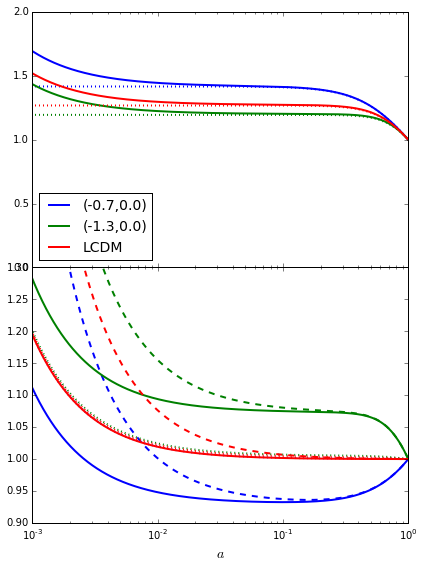

In [86]:
lw=2
fs=14
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6,8),sharex=True,)
#                              gridspec_kw = {'height_ratios':[2, 1]})
for M, csm in cosmo.iteritems():
    if M!='LCDM':
        w0, wa = M.strip('()').split(',')
        if float(wa)!=0.0:
            continue
    bg = csm.get_background()
    a = 1./(bg['z']+1)
    H = bg['H [1/Mpc]']
    grow = bg['grow']
    grow_prime = bg['grow_prime']
    D = bg['gr.fac. D']
    f = bg['gr.fac. f']
    grow_interp = interpolate.interp1d(a,grow)
    p = ax1.semilogx(a,grow/grow[-1]/a,lw=lw,label=M)
    colour = p[0].get_color()
    #ax1.semilogx(a,D/D[-1]/a,lw=lw,ls='--',color=colour)
    #ax1.semilogx(a,D_hypergeom(a,csm)/a,lw=lw,ls=':',color=colour)
    ax1.semilogx(a,D_linder2(a,csm)/a,lw=lw,ls=':',color=colour)

    ax2.semilogx(a,grow/grow[-1]/D_integral2(a,csm),lw=lw,ls='-',color=colour)
    ax2.semilogx(a,grow/grow[-1]/(D/D[-1]),ls='--',lw=lw,color=colour)
    #ax2.semilogx(a,grow/grow[-1]/D_hypergeom(a,csm),lw=lw,ls=':',color=colour)
    ax2.semilogx(a,grow/grow[-1]/D_linder2(a,csm),lw=lw,ls=':',color=colour)

ax1.set_xlim([1e-3,1]) 
ax2.set_xlabel(r'$a$',fontsize=fs)
ax1.set_ylim([0,2])
ax2.set_ylim([0.9,1.3])

lgd1 = ax1.legend(fontsize=fs,ncol=1,loc='lower left')
#           bbox_to_anchor=(1.0, 1.035))

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
fig.savefig('Growthrate_w0.pdf')

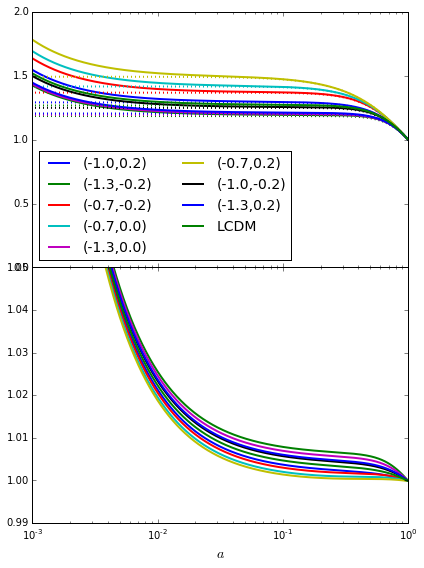

In [85]:
lw=2
fs=14
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6,8),sharex=True,)
#                              gridspec_kw = {'height_ratios':[2, 1]})
for M, csm in cosmo.iteritems():
    #if M!='LCDM':
    #    w0, wa = M.strip('()').split(',')
    #    if float(wa)!=0.0:
    #        continue
    bg = csm.get_background()
    a = 1./(bg['z']+1)
    H = bg['H [1/Mpc]']
    grow = bg['grow']
    grow_prime = bg['grow_prime']
    D = bg['gr.fac. D']
    f = bg['gr.fac. f']
    grow_interp = interpolate.interp1d(a,grow)
    p = ax1.semilogx(a,grow/grow[-1]/a,lw=lw,label=M)
    colour = p[0].get_color()
    #ax1.semilogx(a,D/D[-1]/a,lw=lw,ls='--',color=colour)
    #ax1.semilogx(a,D_hypergeom(a,csm)/a,lw=lw,ls=':',color=colour)
    ax1.semilogx(a,D_linder2(a,csm)/a,lw=lw,ls=':',color=colour)

    #ax2.semilogx(a,grow/grow[-1]/D_integral2(a,csm),lw=lw,ls='-',color=colour)
    #ax2.semilogx(a,grow/grow[-1]/(D/D[-1]),ls='--',lw=lw,color=colour)
    #ax2.semilogx(a,grow/grow[-1]/D_hypergeom(a,csm),lw=lw,ls=':',color=colour)
    ax2.semilogx(a,grow/grow[-1]/D_linder2(a,csm),lw=lw,ls='-',color=colour)

ax1.set_xlim([1e-3,1]) 
ax2.set_xlabel(r'$a$',fontsize=fs)
ax1.set_ylim([0,2])
ax2.set_ylim([0.99,1.05])

lgd1 = ax1.legend(fontsize=fs,ncol=2,loc='lower left')
#           bbox_to_anchor=(1.0, 1.035))

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
fig.savefig('Growthrate_w0.pdf')

In [15]:
print csm.get_background().viewkeys()

dict_keys(['(.)rho_crit', 'grow_prime', 'bwdec', '(.)rho_cdm', 'H_prime', '(.)rho_ur', 'ang.diam.dist.', 'proper time [Gyr]', 'H [1/Mpc]', 'conf. time [Mpc]', 'bwdec_prime', 'lum. dist.', 'gr.fac. f', 'grow', 'comov. dist.', 'Wronskian', '(.)rho_fld', 'comov.snd.hrz.', 'decay', '(.)rho_b', '(.)rho_g', 'gr.fac. D', 'z'])


In [26]:
cosmo['(-1.0,0.2)'].pars

{'Omega_Lambda': 0.0,
 'background_verbose': 1,
 'gauge': 'Newtonian',
 'input_verbose': 1,
 'w0_fld': -1.0,
 'wa_fld': 0.2}

In [58]:
a = np.array([1,2,3])
print a[:0]

[]
